In [27]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

In [28]:
eps_r = 1.0
mu_r = 1.0

In [43]:
T = 10 # Final time
xmin = -1
xmax = 1
ymin = -1
ymax = 1
geom = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
 # Define the spatial domain of the problem
timedomain = dde.geometry.TimeDomain(0, T) # Define the temporal domain of the problem
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [67]:
def cavity_analytical(var, w):
    t = var[:, 0]
    x = var[:, 1]
    y = var[:, 2]
    Hx = -(np.pi / w) * np.sin(np.pi * x) * np.cos(np.pi * y) * np.sin(w * t) 
    Hy = (np.pi / w) * np.cos(np.pi * x) * np.sin(np.pi * y) * np.sin(w * t) 
    Ez = np.sin(np.pi * x) * np.sin(np.pi * y) * np.cos(w * t) 
    return Hx, Hy, Ez

def initial_cavity(var):
    x, y = var[:, 1], var[:, 2]
    Hx = np.zeros_like(x)
    Hy = np.zeros_like(x)
    Ez = np.sin(np.pi * x) * np.sin(np.pi * y)

    return np.array([Hx, Hy, Ez])

def PEC_condition(var, on_boundary):
    return [0, 0, 0]

In [69]:
def pde(var, out): # Define the system of PDEs for Maxwell 2D
    t = var[:, 0]
    x = var[:, 1]
    y = var[:, 2]
    Hx = out[:, 0]
    Hy = out[:, 1]
    Ez = out[:, 2]
    dEz_t = dde.grad.jacobian(Ez, t, i=0, j=0)
    dEz_x = dde.grad.jacobian(Ez, x, i=0, j=0)
    dEz_y = dde.grad.jacobian(Ez, y, i=0, j=0)
    dHx_t = dde.grad.jacobian(Hx, t, i=0, j=0)
    dHx_y = dde.grad.jacobian(Hx, y, i=0, j=0)
    dHy_t = dde.grad.jacobian(Hy, t, i=0, j=0)
    dHy_x = dde.grad.jacobian(Hy, x, i=0, j=0)
    res_Ez = dEz_t - 1 / eps_r * (dHy_x - dHx_y)
    res_Hx = dHx_t + 1 / mu_r * dEz_y
    res_Hy = dHy_t - 1 / mu_r * dEz_x
    return np.array([res_Hx, res_Hy, res_Ez])

In [32]:
def boundary(_, on_boundary):
    return on_boundary


In [75]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: np.zeros_like(x), lambda _, on_boundary: on_boundary) # Define Dirichlet boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: initial_cavity(x), lambda _, on_initial: on_initial) # Define initial conditions

In [76]:
N_domain = 2540 # Number of training samples in the domain
N_boundary = 80 # Number of training samples on the boundary
N_initial = 160 # Number of training samples for the initial condition

data = dde.data.TimePDE(geomtime, pde, [bc, ic], #  Define the PDE problem wit
                        num_domain=N_domain, num_boundary=N_boundary, num_initial=N_initial)

In [77]:
net = dde.nn.FNN([3] + [20] * 3 + [3], "tanh", "Glorot normal")

In [78]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000406 s



In [79]:
losshistory, train_state = model.train(iterations=1500)

Training model...



IndexError: tuple index out of range

Saving loss history to /home/rgelly/Documents/MasterIM/MachineLearning/TP1/loss.dat ...
Saving training data to /home/rgelly/Documents/MasterIM/MachineLearning/TP1/train.dat ...
Saving test data to /home/rgelly/Documents/MasterIM/MachineLearning/TP1/test.dat ...


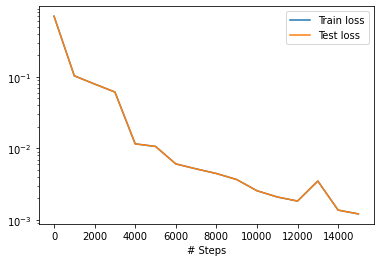

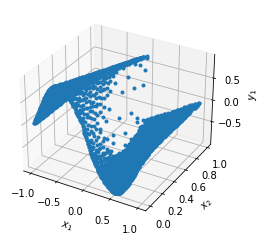

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
X, y_true = gen_testdata() # Load reference solution
y_pred = model.predict(X) # Predict solution from network
f = model.predict(X, operator=pde) # Compute PDE residual
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

t.shape:  (100, 1)
x.shape:  (256, 1)
Mean residual: 0.016651733
L2 relative error: 0.07965886250530299


(2,)


In [ ]:
t_array, x_array = np.reshape(X[:,1], (100, 256))[:,0], np.reshape(X[:,0], (100, 256))[0,:]
ypred_array = np.reshape(y_pred, (100, 256))
ytrue_array = np.reshape(y_true, (100, 256))

In [ ]:
ypred_array.shape

(100, 256)

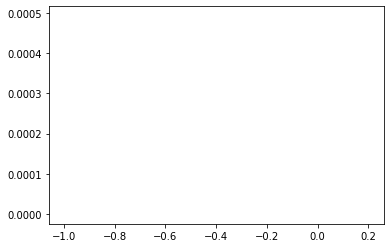

In [ ]:
# Plot network solution and reference solution at different t

t_snap = 0.2
idx_t = np.argmin(np.abs(t_array - t_snap)) # Find the index of the snapshot closest to t_snap
xt = x_array[idx_t]
yt_pred = y_pred[idx_t]
yt_true = y_true[idx_t]

plt.figure()
plt.plot(xt[0], yt_true, label="True")
plt.plot(xt[1], yt_pred, label="Prediction")


In [ ]:
X.shape

(25600, 2)